# DACON - 영화 관객수 예측 경진대회
[DACON - 영화 관객수 예측 경진대회](https://dacon.io/competitions/open/235536/data)
## EDA and Preprocessing

### 사용 라이브러리



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib
import re
from glob import glob
import warnings
warnings.filterwarnings("ignore")

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score

import xgboost as xgb
from xgboost import XGBRegressor

import lightgbm as lgbm
from lightgbm import LGBMRegressor

xgboost와 lgbm을 사용했지만, 다른 모델을 사용해도 상관 없습니다

### Data Load

In [2]:
paths = glob('영화 관객수/*.csv')
paths

['영화 관객수\\movies_test.csv',
 '영화 관객수\\movies_train.csv',
 '영화 관객수\\submission.csv']

In [3]:
train, test = pd.read_csv(paths[1]), pd.read_csv(paths[0])

train.shape, test.shape

((600, 12), (243, 11))

In [4]:
# train과 test의 데이터를 출력해봅니다
display(train.head(3))
display(test.head(3))

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,NaN,0,91,2,23398
1,내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501
2,은밀하게 위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083


,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor
0,용서는 없다,시네마서비스,느와르,2010-01-07,125,청소년 관람불가,김형준,3.005290e+05,2,304,3
1,아빠가 여자를 좋아해,(주)쇼박스,멜로/로맨스,2010-01-14,113,12세 관람가,이광재,3.427002e+05,4,275,3
2,하모니,CJ 엔터테인먼트,드라마,2010-01-28,115,12세 관람가,강대규,4.206611e+06,3,419,7


- title : 영화의 제목
- distributor : 배급사
- genre : 장르
- release_time : 개봉일
- time : 상영시간(분)
- screening_rat : 상영등급
- director : 감독이름
- dir_prev_bfnum : 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화에서의 평균 관객수(단 관객수가 알려지지 않은 영화 제외)
- dir_prev_num : 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화의 개수(단 관객수가 알려지지 않은 영화 제외)
- num_staff : 스텝수
- num_actor : 주연배우수
- box_off_num : 관객수

### EDA and Preprocessing
#### 기본 정보

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           600 non-null    object 
 1   distributor     600 non-null    object 
 2   genre           600 non-null    object 
 3   release_time    600 non-null    object 
 4   time            600 non-null    int64  
 5   screening_rat   600 non-null    object 
 6   director        600 non-null    object 
 7   dir_prev_bfnum  270 non-null    float64
 8   dir_prev_num    600 non-null    int64  
 9   num_staff       600 non-null    int64  
 10  num_actor       600 non-null    int64  
 11  box_off_num     600 non-null    int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 56.4+ KB


In [6]:
# 통계값을 소수점 2자리까지만 확인 해봅니다 (train)
pd.options.display.float_format = '{:.2f}'.format
train.describe()

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
count,600.00,270.00,600.00,600.00,600.00,600.00
mean,100.86,1050442.89,0.88,151.12,3.71,708181.75
std,18.10,1791408.30,1.18,165.65,2.45,1828005.85
min,45.00,1.00,0.00,0.00,0.00,1.00
25%,89.00,20380.00,0.00,17.00,2.00,1297.25
50%,100.00,478423.62,0.00,82.50,3.00,12591.00
75%,114.00,1286568.62,2.00,264.00,4.00,479886.75
max,180.00,17615314.00,5.00,869.00,25.00,14262766.00


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 0 to 242
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           243 non-null    object 
 1   distributor     243 non-null    object 
 2   genre           243 non-null    object 
 3   release_time    243 non-null    object 
 4   time            243 non-null    int64  
 5   screening_rat   243 non-null    object 
 6   director        243 non-null    object 
 7   dir_prev_bfnum  107 non-null    float64
 8   dir_prev_num    243 non-null    int64  
 9   num_staff       243 non-null    int64  
 10  num_actor       243 non-null    int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 21.0+ KB


In [8]:
# 통계값을 소수점 2자리까지만 확인 해봅니다 (test)
test.describe()

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor
count,243.00,107.00,243.00,243.00,243.00
mean,109.80,891669.52,0.85,159.32,3.48
std,124.02,1217341.45,1.20,162.98,2.11
min,40.00,34.00,0.00,0.00,0.00
25%,91.00,62502.00,0.00,18.00,2.00
50%,104.00,493120.00,0.00,105.00,3.00
75%,114.50,1080849.58,1.00,282.00,4.00
max,2015.00,6173099.50,6.00,776.00,16.00


#### 결측치 확인

In [9]:
# train
train.isnull().sum()

title               0
distributor         0
genre               0
release_time        0
time                0
screening_rat       0
director            0
dir_prev_bfnum    330
dir_prev_num        0
num_staff           0
num_actor           0
box_off_num         0
dtype: int64

In [10]:
# test
test.isnull().sum()

title               0
distributor         0
genre               0
release_time        0
time                0
screening_rat       0
director            0
dir_prev_bfnum    136
dir_prev_num        0
num_staff           0
num_actor           0
dtype: int64

<AxesSubplot: >

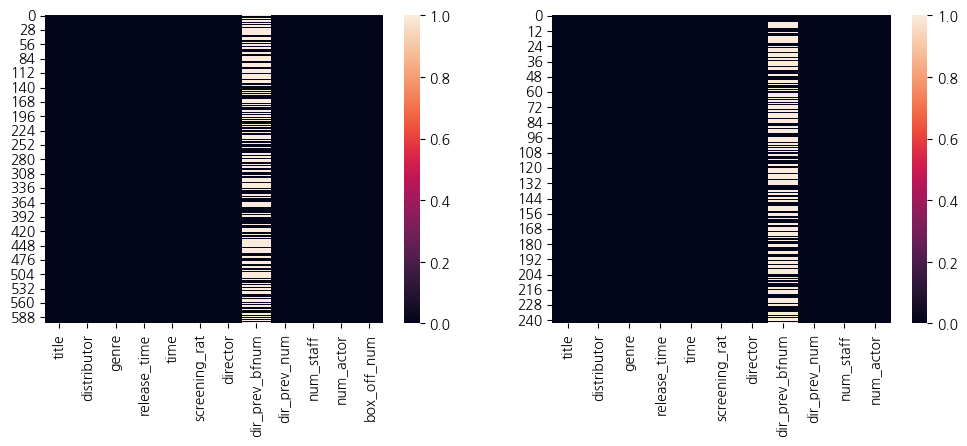

In [11]:
# 결측치를 시각화해봅니다
fig, ax = plt.subplots(1, 2, figsize=(12,4))
sns.heatmap(train.isnull(), ax=ax[0])
sns.heatmap(test.isnull(), ax=ax[1])

`dir_prev_bfnum`은 해당 감독이 영화를 만들기 전 제작에 참여한 영화에서의 평균 관객수부분에 결측치가 존재함  
관객수가 알려지지 않은 부분이 결측치로 존재하는거라, 정보가 없다라는 정보 그 자체로 사용해도 괜찮을꺼 같음

#### distributor: 배급사

In [12]:
# \(|주|\) 는 데이터에서 제거해줍니다
train["distributor"] = train["distributor"].str.replace("\(주\)", "")
test["distributor"] = test["distributor"].str.replace("\(주\)", "")

Text(0.5, 1.0, 'Test - distributor')

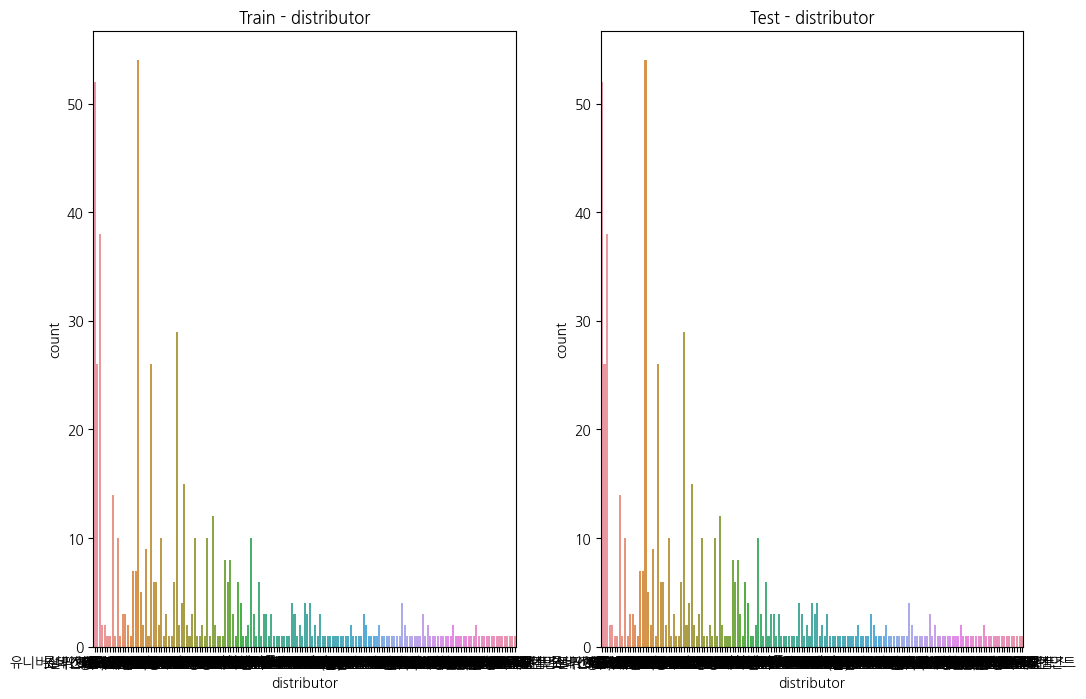

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(12, 8))
sns.countplot(data=train, x='distributor', ax=ax[0]).set_title("Train - distributor")
sns.countplot(data=train, x='distributor', ax=ax[1]).set_title("Test - distributor")

In [14]:
# 정규 표현식으로 문자와 숫자만 
train["distributor"] = [re.sub(r'[^0-9a-zA-Z가-힣]', '', x) for x in train.distributor]
test['distributor'] = [re.sub(r'[^0-9a-zA-Z가-힣]', '', x) for x in test.distributor]

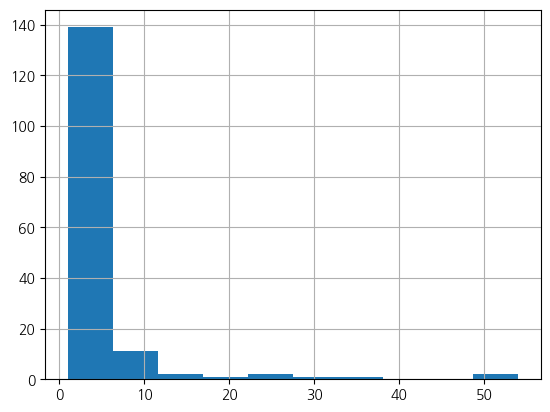

In [15]:
_ = train["distributor"].value_counts().hist()

In [16]:
# 배급사의 개수를 이용해 소형, 중대형으로 분리하기 위한 함수를 작성합니다
# 15개 이하면 소형, 이외면 중대형으로 분류 합니다
df = train['distributor'].value_counts() > 15
df = df[df == True].index.to_list()

def distributor_band(x):
    if x in df:
        return '중대형'
    else:
        return '소형'

In [17]:
df

['CJ엔터테인먼트', '롯데엔터테인먼트', 'NEW', '마운틴픽쳐스', '인디스토리', '쇼박스', '시네마달']

In [18]:
train["distributor"].apply(distributor_band).value_counts()

소형     357
중대형    243
Name: distributor, dtype: int64

In [19]:
test["distributor"].apply(distributor_band).value_counts()

소형     133
중대형    110
Name: distributor, dtype: int64

In [20]:
# 위 함수를 train과 test에 모두 적용합니다
train["distributor"] = train["distributor"].apply(distributor_band)
test["distributor"] = test["distributor"].apply(distributor_band)

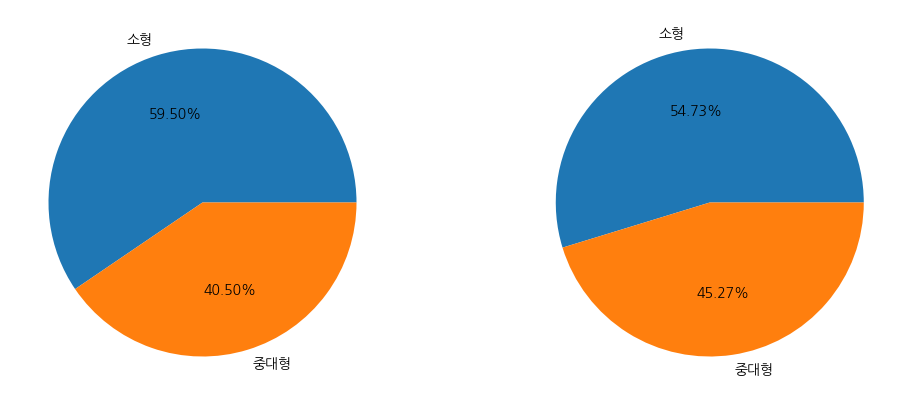

In [21]:
# pie 차트는 다음과 같이 그릴 수 있습니다
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].pie(train["distributor"].value_counts().values, labels=train["distributor"].value_counts().index, autopct="%.2f%%")
ax[1].pie(test["distributor"].value_counts().values, labels=test["distributor"].value_counts().index, autopct="%.2f%%")
plt.show()

#### genre: 장르


In [22]:
train.groupby("genre")["box_off_num"].mean().sort_values()

genre
뮤지컬         6627.00
다큐멘터리      67172.26
서스펜스       82611.00
애니메이션     181926.67
멜로/로맨스    425968.04
미스터리      527548.18
공포        590832.52
드라마       625689.79
코미디      1193914.00
SF       1788345.69
액션       2203974.07
느와르      2263695.11
Name: box_off_num, dtype: float64

In [23]:
# 위에서 구한 장르로
# rank 딕셔너리를 하드코딩합니다
# 인코딩하는 과정입니다
rank = {'뮤지컬' : 1, '다큐멘터리' : 2, '서스펜스' : 3, '애니메이션' : 4, '멜로/로맨스' : 5, '미스터리' : 6, '공포' : 7, '드라마' : 8,
        '코미디' : 9, 'SF' : 10, '액션' : 11, '느와르' : 12 }

In [24]:
train["rank_genre"] = train["genre"].apply(lambda x: rank[x])
test["rank_genre"] = test["genre"].apply(lambda x: rank[x])

In [25]:
# 인코딩 전의 장르 컬럼은 버려줍니다
train = train.drop(columns = 'genre')
test = test.drop(columns = 'genre')

In [26]:
train.head(2)

,title,distributor,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,rank_genre
0,개들의 전쟁,중대형,2012-11-22,96,청소년 관람불가,조병옥,NaN,0,91,2,23398,11
1,내부자들,중대형,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501,12


In [27]:
test.head(2)

,title,distributor,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,rank_genre
0,용서는 없다,소형,2010-01-07,125,청소년 관람불가,김형준,300529.00,2,304,3,12
1,아빠가 여자를 좋아해,중대형,2010-01-14,113,12세 관람가,이광재,342700.25,4,275,3,5


### release_time: 개봉일

In [28]:
# 개봉일의 데이터타입은 datetime으로 변경합니다
train['release_time'] = pd.to_datetime(train['release_time'])
test['release_time'] = pd.to_datetime(test['release_time'])

In [29]:
# 연 월 일 요일 파생 변수를 train과 test에 생성합니다
train['year'] = train['release_time'].dt.year
train['month'] = train['release_time'].dt.month
train['day'] = train['release_time'].dt.day
train['dayofweek'] = train['release_time'].dt.dayofweek

In [30]:
test['year'] = test['release_time'].dt.year
test['month'] = test['release_time'].dt.month
test['day'] = test['release_time'].dt.day
test['dayofweek'] = test['release_time'].dt.dayofweek

In [31]:
# 기존 데이터는 삭제합니다
train = train.drop('release_time',axis=1)


In [42]:
test.columns

Index(['title', 'distributor', 'release_time', 'time', 'screening_rat',
       'director', 'dir_prev_bfnum', 'dir_prev_num', 'num_staff', 'num_actor',
       'rank_genre', 'year', 'month', 'day', 'dayofweek'],
      dtype='object')

In [47]:
test = test.drop('release_time',axis=1)

In [48]:
display(train.shape)
train.head(2)

(600, 15)

,title,distributor,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,rank_genre,year,month,day,dayofweek
0,개들의 전쟁,중대형,96,청소년 관람불가,조병옥,0.00,0,91,2,23398,11,2012,11,22,3
1,내부자들,중대형,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501,12,2015,11,19,3


In [49]:
display(test.shape)
test.head(2)

(243, 14)

,title,distributor,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,rank_genre,year,month,day,dayofweek
0,용서는 없다,소형,125,청소년 관람불가,김형준,300529.00,2,304,3,12,2010,1,7,3
1,아빠가 여자를 좋아해,중대형,113,12세 관람가,이광재,342700.25,4,275,3,5,2010,1,14,3


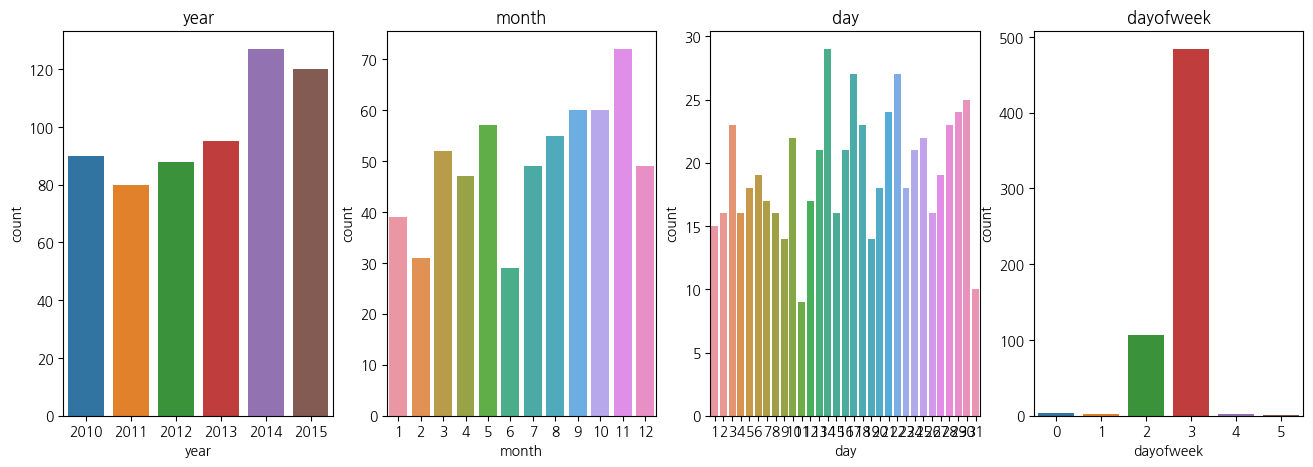

In [52]:
# 요일별로 시각화 해봅니다
fig, ax = plt.subplots(1, 4, figsize=(16,5))
sns.countplot(data = train, x = 'year',  ax = ax[0]).set_title('year')
sns.countplot(data = train, x = 'month',ax = ax[1]).set_title('month')
sns.countplot(data = train, x = 'day', ax = ax[2]).set_title('day')
sns.countplot(data = train, x = 'dayofweek', ax = ax[3]).set_title('dayofweek');

수요일, 목요일에 개봉한 영화들이 많고 목요일에 개봉한 영화가 유독 많음

## Train

In [57]:
train.head(2)

,distributor,time,screening_rat,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,rank_genre,year,month,day,dayofweek
0,중대형,96,청소년 관람불가,0.00,0,91,2,23398,11,2012,11,22,3
1,중대형,130,청소년 관람불가,1161602.50,2,387,3,7072501,12,2015,11,19,3


In [56]:
# 제목과 감독 데이터는 버려줍니다
train = train.drop(['title', 'director'], axis=1)
test = test.drop(['title', 'director'], axis=1)

KeyError: "['title', 'director'] not found in axis"

In [37]:
train["dir_prev_bfnum"].fillna(0, inplace=True)
test["dir_prev_bfnum"].fillna(0, inplace=True)

In [59]:
display(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   distributor     600 non-null    object 
 1   time            600 non-null    int64  
 2   screening_rat   600 non-null    object 
 3   dir_prev_bfnum  600 non-null    float64
 4   dir_prev_num    600 non-null    int64  
 5   num_staff       600 non-null    int64  
 6   num_actor       600 non-null    int64  
 7   box_off_num     600 non-null    int64  
 8   rank_genre      600 non-null    int64  
 9   year            600 non-null    int64  
 10  month           600 non-null    int64  
 11  day             600 non-null    int64  
 12  dayofweek       600 non-null    int64  
dtypes: float64(1), int64(10), object(2)
memory usage: 61.1+ KB


None

In [60]:
# 범주형 데이터들을 인코딩해줍니다
train = pd.get_dummies(train)
test = pd.get_dummies(test)

In [63]:
set(train.columns.to_list()) - set(test.columns.to_list())

{'box_off_num'}

In [64]:
feature_names = ['time',
 'dir_prev_bfnum',
 'dir_prev_num',
 'num_staff',
 'num_actor',
 'rank_genre',
 'year',
 'month',
 'day',
 'dayofweek',
 'distributor_소형',
 'distributor_중대형',
 'screening_rat_12세 관람가',
 'screening_rat_15세 관람가',
 'screening_rat_전체 관람가',
 'screening_rat_청소년 관람불가']

In [65]:
label = 'box_off_num'

### Log Scale

In [67]:
# 등장 배우의 수에 로그 스케일을 적용합니다
train['num_actor'] = np.log1p(train['num_actor'])

In [69]:
X_train, X_val, y_train, y_val = train_test_split(train[feature_names], train[label], test_size=0.15)

print(f"X_train: {X_train.shape}\ny_train: {y_train.shape}\nX_val: {X_val.shape}\ny_val: {y_val.shape}")

X_train: (510, 16)
y_train: (510,)
X_val: (90, 16)
y_val: (90,)


In [70]:
test.shape

(243, 479)

### Random Forest

In [71]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
model = RandomForestRegressor(random_state= 42, n_jobs = -1)
y_predict = model.fit(X_train, y_train).predict(X_val)
mean_squared_error(y_val, y_predict) ** (0.5)

1565096.548115836

<AxesSubplot: >

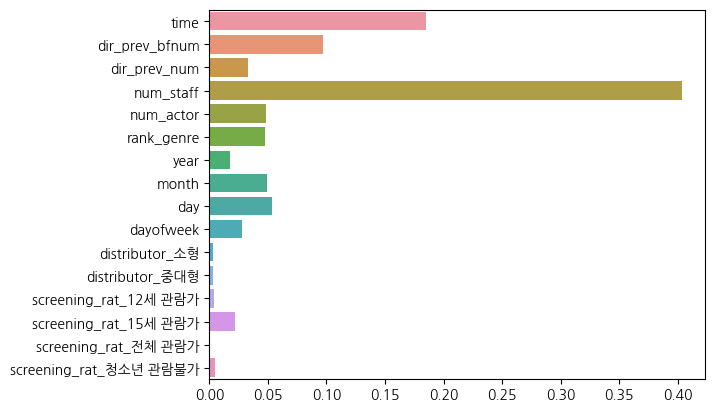

In [72]:
sns.barplot(x = model.feature_importances_, y = model.feature_names_in_)

### XGBoost

In [73]:
model_xgb = xgb.XGBRegressor(random_state = 42, n_jobs=-1)
y_predict_xgb = model_xgb.fit(X_train, y_train).predict(X_val)
mean_squared_error(y_val, y_predict_xgb) ** (0.5)

1529899.5378112076

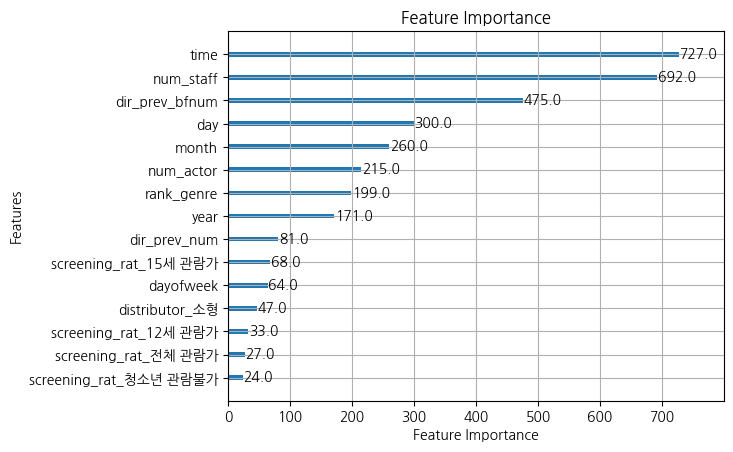

In [77]:
ax = xgb.plot_importance(model_xgb, max_num_features=len(feature_names))
ax.set(title=f'Feature Importance',
    xlabel='Feature Importance',
    ylabel='Features');

### LightGBM

In [78]:
pip install LightGBM

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [81]:
model_lgbm = lgbm.LGBMRegressor(random_state = 42, n_jobs=1)
y_predict_lgbm = model_lgbm.fit(X_train, y_train).predict(X_val)
mean_squared_error(y_val, y_predict_lgbm) ** (0.5)

1420858.8629261085

[Text(0.5, 1.0, 'Feature Importance'),
 Text(0.5, 0, 'Feature Importance'),
 Text(0, 0.5, 'Features')]

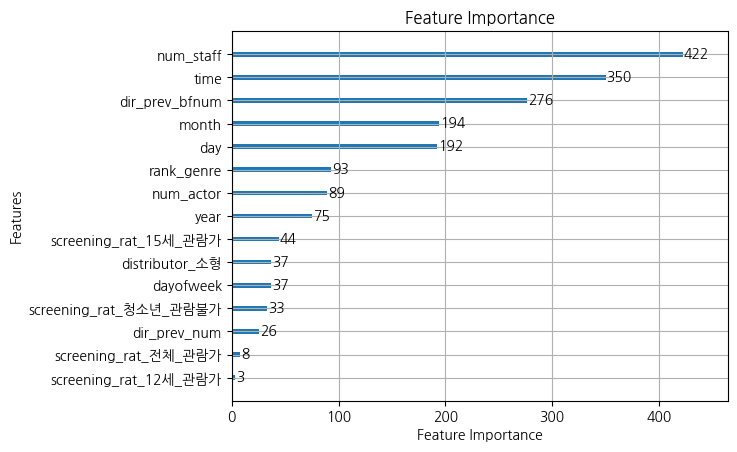

In [82]:
ax = lgbm.plot_importance(model_lgbm, max_num_features=len(feature_names))
ax.set(title=f'Feature Importance',
    xlabel='Feature Importance',
    ylabel='Features')